<a href="https://colab.research.google.com/github/rokon343/CNN_Fruits_Classification/blob/main/210120_CNN_Fruits_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/rokon343/CNN_Fruits_Classification.git
%cd CNN_Fruits_Classification
!ls


Cloning into 'CNN_Fruits_Classification'...
remote: Enumerating objects: 3268, done.
remote: Counting objects: 100% (3268/3268), done.
remote: Compressing objects: 100% (3266/3266), done.
remote: Total 3268 (delta 0), reused 3268 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3268/3268), 31.51 MiB | 17.53 MiB/s, done.
/content/CNN_Fruits_Classification
Custom	Model  README.md


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])


In [5]:
train_dir = "Model/train"
test_dir  = "Model/test"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)


Classes: ['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Number of classes: 10


In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [7]:
model = CNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
num_epochs = 15

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {epoch_loss:.4f} "
          f"Accuracy: {epoch_acc:.2f}%")


Epoch [1/15] Loss: 1.9127 Accuracy: 27.25%
Epoch [2/15] Loss: 1.5231 Accuracy: 44.24%
Epoch [3/15] Loss: 1.3356 Accuracy: 50.80%
Epoch [4/15] Loss: 1.1556 Accuracy: 58.89%
Epoch [5/15] Loss: 0.9792 Accuracy: 66.36%
Epoch [6/15] Loss: 0.8541 Accuracy: 70.23%
Epoch [7/15] Loss: 0.7151 Accuracy: 74.36%
Epoch [8/15] Loss: 0.5422 Accuracy: 81.31%
Epoch [9/15] Loss: 0.3607 Accuracy: 87.05%
Epoch [10/15] Loss: 0.2869 Accuracy: 90.35%
Epoch [11/15] Loss: 0.2535 Accuracy: 91.61%
Epoch [12/15] Loss: 0.1869 Accuracy: 93.92%
Epoch [13/15] Loss: 0.1181 Accuracy: 95.91%
Epoch [14/15] Loss: 0.1202 Accuracy: 96.18%
Epoch [15/15] Loss: 0.1100 Accuracy: 96.26%


In [9]:
torch.save(model.state_dict(), "Model/fruits_cnn_10_classes.pth")
print("Model saved successfully!")


Model saved successfully!


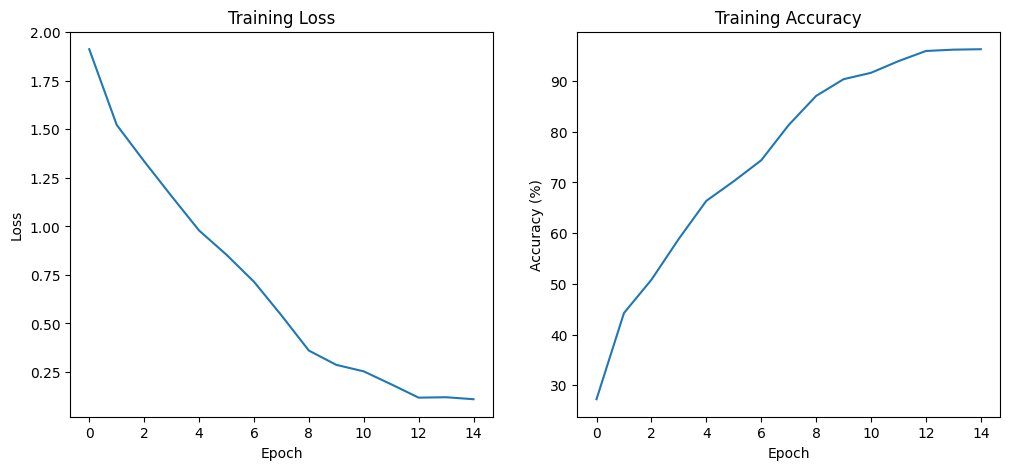

In [10]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.show()


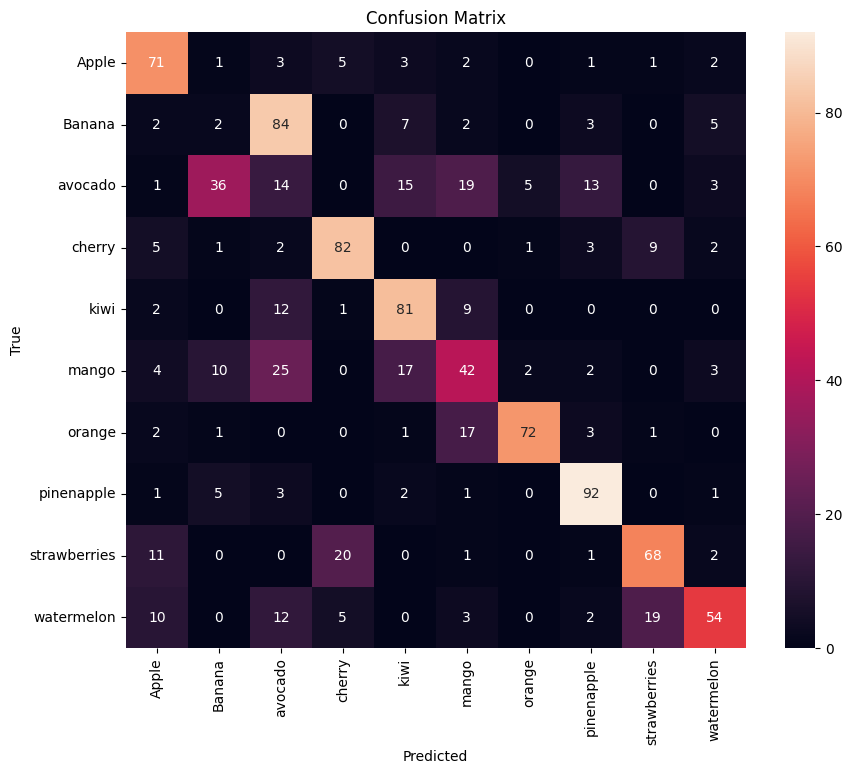

In [11]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


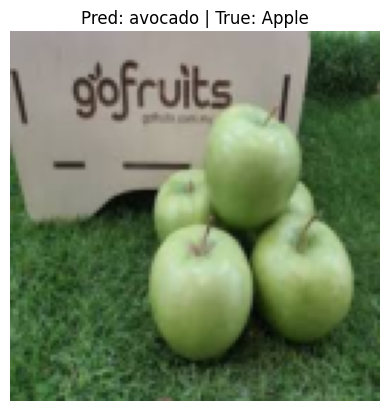

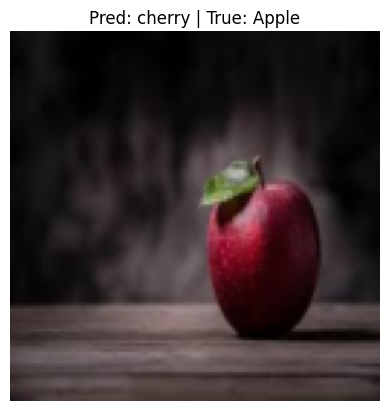

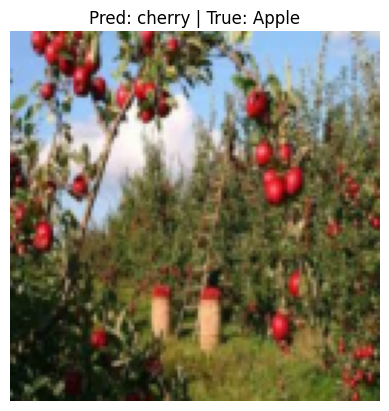

In [12]:
wrong = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong.append((images[i].cpu(), preds[i], labels[i]))

for i in range(min(3, len(wrong))):
    img, pred, true = wrong[i]
    img = img.permute(1,2,0) * 0.5 + 0.5
    plt.imshow(img)
    plt.title(f"Pred: {class_names[pred]} | True: {class_names[true]}")
    plt.axis("off")
    plt.show()


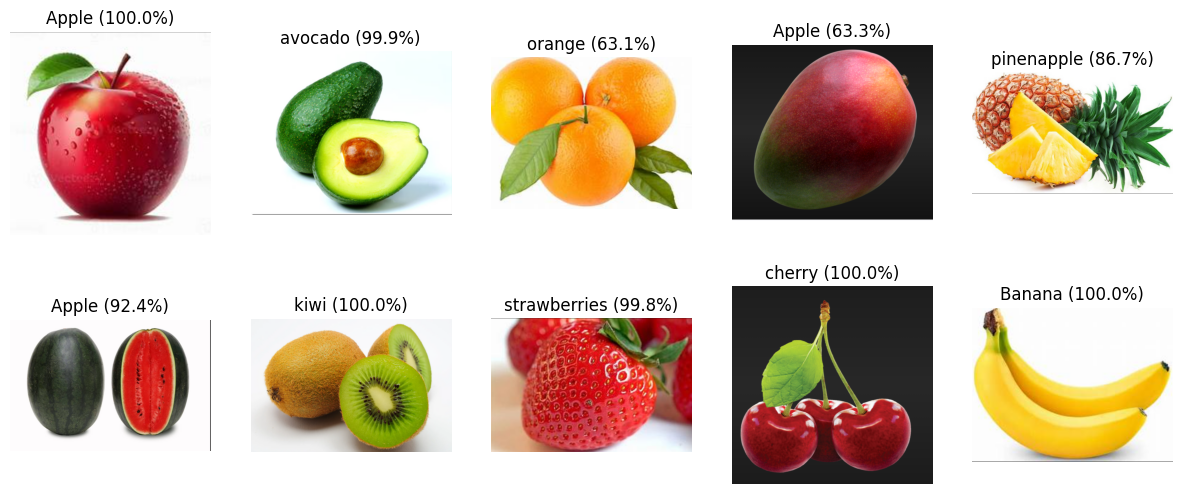

In [13]:
custom_dir = "Custom"
model.eval()

plt.figure(figsize=(15,6))

for idx, img_name in enumerate(os.listdir(custom_dir)):
    img_path = os.path.join(custom_dir, img_name)

    image = Image.open(img_path).convert("RGB")
    image_t = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_t)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)

    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f"{class_names[pred]} ({conf.item()*100:.1f}%)")
    plt.axis("off")

plt.show()
